
# Retail Demand Forecasting — Basics & Classical Models

This notebook contains the converted script for the **basics and classical forecasting models** (baselines, SARIMA, Holt-Winters, Prophet) applied to weekly retail sales data.
Run cells in order. If `prophet` import fails, install `prophet` (or `fbprophet`).


In [18]:
# 1) Install required packages (run once per session)
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn pmdarima statsmodels prophet==1.2.1

# Note: prophet may take a minute to install. If it fails, you can remove Prophet usage or use Colab's builtin packages.


In [19]:
# 2) Mount Google Drive for persistent saving
from google.colab import drive
drive.mount('/content/drive')  # will prompt for authorization


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

import pmdarima as pm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception:
        print("Prophet import failed. Please install 'prophet' or 'fbprophet'.")
%matplotlib inline


In [21]:
DATE_COL = "Date"
TARGET = "Weekly_Sales"

def load_and_prepare(path):
    df = pd.read_csv(path)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], format="%d-%m-%Y")
    df = df.sort_values(['Store', DATE_COL]).reset_index(drop=True)
    return df

def store_series(df, store_id):
    s = df[df['Store'] == store_id].copy()
    s = s.set_index(DATE_COL).asfreq('W-FRI') # Changed 'W-MON' to 'W-FRI'
    return s

def fill_missing(s):
    s_filled = s.interpolate(method='time').ffill().bfill()
    return s_filled

def time_train_test_split(s, n_test_weeks=52, target=TARGET):
    test = s.tail(n_test_weeks)
    train = s.iloc[:-n_test_weeks]
    return train, test

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mape(y_true, y_pred)
    }

In [22]:

def naive_forecast(train, test, target=TARGET):
    last = train[target].iloc[-1]
    preds = np.repeat(last, len(test))
    preds = pd.Series(preds, index=test.index)
    return preds

def seasonal_naive(train, test, target=TARGET, season_weeks=52):
    preds = []
    for dt in test.index:
        val_idx = dt - pd.Timedelta(weeks=season_weeks)
        if val_idx in train.index:
            preds.append(train.loc[val_idx, target])
        else:
            preds.append(train[target].iloc[-1])
    return pd.Series(preds, index=test.index)

def moving_average_forecast(train, test, target=TARGET, window=4):
    val = train[target].rolling(window=window).mean().iloc[-1]
    preds = np.repeat(val, len(test))
    return pd.Series(preds, index=test.index)


In [23]:

def sarima_forecast(train, test, exog_cols=None, seasonal=True, m=52):
    y = train[TARGET].values
    exog_train = train[exog_cols].values if exog_cols is not None else None
    exog_test = test[exog_cols].values if exog_cols is not None else None

    model = pm.auto_arima(y, exogenous=exog_train,
                          seasonal=seasonal, m=m,
                          stepwise=True, error_action='ignore',
                          suppress_warnings=True, trace=False)
    n_periods = len(test)
    fc, conf_int = model.predict(n_periods=n_periods, exogenous=exog_test, return_conf_int=True)
    preds = pd.Series(fc, index=test.index)
    return preds, model

def holt_winters_forecast(train, test, seasonal_periods=52, trend='add', seasonal='add'):
    model = ExponentialSmoothing(train[TARGET], trend=trend, seasonal=seasonal,
                                 seasonal_periods=seasonal_periods, damped_trend=False)
    fit = model.fit(optimized=True)
    preds = fit.forecast(len(test))
    preds = pd.Series(preds, index=test.index)
    return preds, fit

def prophet_forecast(train, test, regressors=None):
    df_train = train.reset_index().rename(columns={DATE_COL: 'ds', TARGET: 'y'})
    df_test = test.reset_index().rename(columns={DATE_COL: 'ds', TARGET: 'y'})

    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    if regressors:
        for r in regressors:
            m.add_regressor(r)
    m.fit(df_train)

    future = df_test[['ds']].copy()
    if regressors:
        for r in regressors:
            future[r] = test[r].values
    forecast = m.predict(future)
    preds = forecast.set_index('ds')['yhat']
    preds.index = pd.to_datetime(preds.index)
    preds = preds.reindex(test.index)
    return preds, m


In [24]:

def plot_forecasts(train, test, preds_dict):
    plt.figure(figsize=(12,5))
    plt.plot(train[TARGET], label='train')
    plt.plot(test[TARGET], label='test', color='k')
    for name, preds in preds_dict.items():
        if preds is not None:
            plt.plot(preds, label=name)
    plt.legend()
    plt.title('Forecast comparison')
    plt.show()

def run_store_pipeline(df, store_id, n_test_weeks=52, exog_cols=['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']):
    print(f"Running pipeline for store {store_id}")
    s = store_series(df, store_id)
    s = fill_missing(s)
    train, test = time_train_test_split(s, n_test_weeks=n_test_weeks)
    print("Train range:", train.index.min(), "-", train.index.max())
    print("Test range:", test.index.min(), "-", test.index.max())

    preds_naive = naive_forecast(train, test)
    preds_seasonal_naive = seasonal_naive(train, test, season_weeks=52)
    preds_ma = moving_average_forecast(train, test, window=4)

    exogs = [c for c in exog_cols if c in df.columns]
    try:
        preds_sarima, sarima_model = sarima_forecast(train, test, exog_cols=exogs, seasonal=True, m=52)
    except Exception as e:
        print("SARIMA failed:", e)
        preds_sarima = pd.Series(np.nan, index=test.index)

    try:
        preds_hw, hw_fit = holt_winters_forecast(train, test, seasonal_periods=52)
    except Exception as e:
        print("Holt-Winters failed:", e)
        preds_hw = pd.Series(np.nan, index=test.index)

    try:
        preds_prophet, prophet_model = prophet_forecast(train, test, regressors=exogs)
    except Exception as e:
        print("Prophet failed:", e)
        preds_prophet = pd.Series(np.nan, index=test.index)

    results = {}
    for name, p in [('Naive', preds_naive), ('SeasonalNaive', preds_seasonal_naive),
                    ('MA', preds_ma), ('SARIMA', preds_sarima),
                    ('HoltWinters', preds_hw), ('Prophet', preds_prophet)]:
        try:
            res = evaluate(test[TARGET].values, p.values)
            results[name] = res
        except Exception as e:
            results[name] = {'error': str(e)}

    preds_dict = {
        'Naive': preds_naive, 'SeasonalNaive': preds_seasonal_naive,
        'MA': preds_ma, 'SARIMA': preds_sarima,
        'HoltWinters': preds_hw, 'Prophet': preds_prophet
    }
    plot_forecasts(train, test, preds_dict)

    return results, preds_dict


Running pipeline for store 1
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


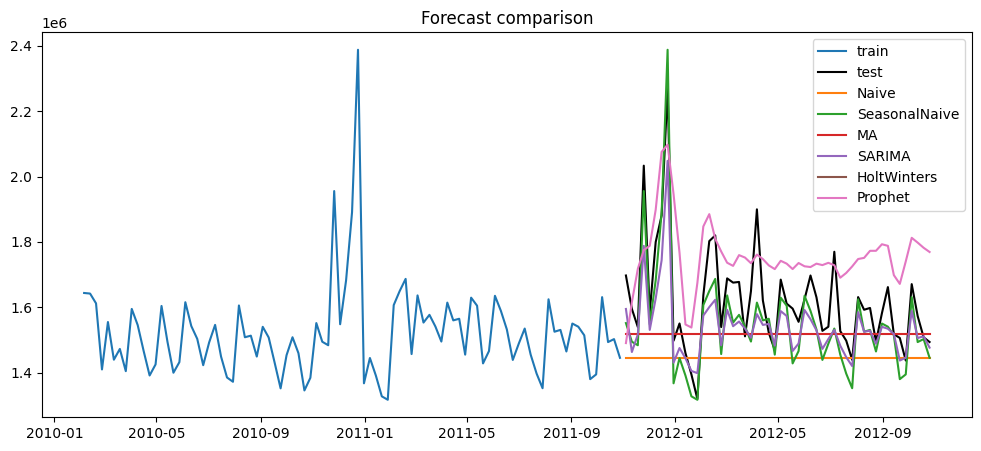

Evaluation results:
Naive {'MAE': 179401.16923076918, 'RMSE': np.float64(234850.378215581), 'MAPE': np.float64(10.404569468115728)}
SeasonalNaive {'MAE': 79533.98326923075, 'RMSE': np.float64(97907.15658930359), 'MAPE': np.float64(4.825980893872581)}
MA {'MAE': 126481.00846153845, 'RMSE': np.float64(188141.79982698068), 'MAPE': np.float64(7.252319793482355)}
SARIMA {'MAE': 85670.8133671024, 'RMSE': np.float64(110773.41391193744), 'MAPE': np.float64(5.026752661273623)}
HoltWinters {'error': 'Input contains NaN.'}
Prophet {'MAE': 168911.36350863535, 'RMSE': np.float64(190336.0626137803), 'MAPE': np.float64(10.760087482285806)}


In [25]:
path = "/content/Walmart_Data_Analysis_and_Forcasting.csv"
df = load_and_prepare(path)
results, preds = run_store_pipeline(df, store_id=1, n_test_weeks=52)
print("Evaluation results:")
for k,v in results.items():
    print(k, v)

In [26]:
import json, os
out_dir = "/content/drive/MyDrive/forecasting_project/results"
os.makedirs(out_dir, exist_ok=True)

# preds and metrics are from your last run_store_pipeline call
# Save predictions:
preds_df = pd.concat(preds, axis=1)   # preds is the dict returned
preds_df.to_csv(os.path.join(out_dir, "store1_forecasts.csv"))

# Save metrics:
with open(os.path.join(out_dir, "store1_metrics.json"), "w") as f:
    json.dump(results, f, indent=2)

print("Saved forecasts and metrics to:", out_dir)


Saved forecasts and metrics to: /content/drive/MyDrive/forecasting_project/results


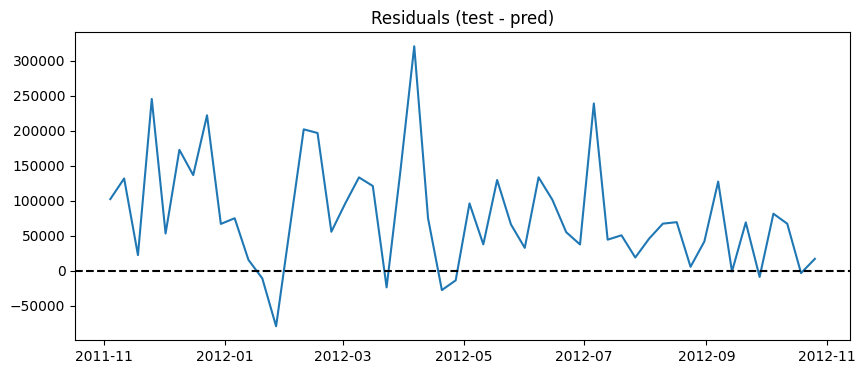

In [28]:
# Re-define test as it's not globally available from run_store_pipeline
s = store_series(df, store_id=1)
s = fill_missing(s)
train, test = time_train_test_split(s, n_test_weeks=52)

resid = test[ "Weekly_Sales"].values - preds['SARIMA'].values  # or choose model
plt.figure(figsize=(10,4))
plt.plot(test.index, resid)
plt.axhline(0, color='k', linestyle='--')
plt.title('Residuals (test - pred)')
plt.show()

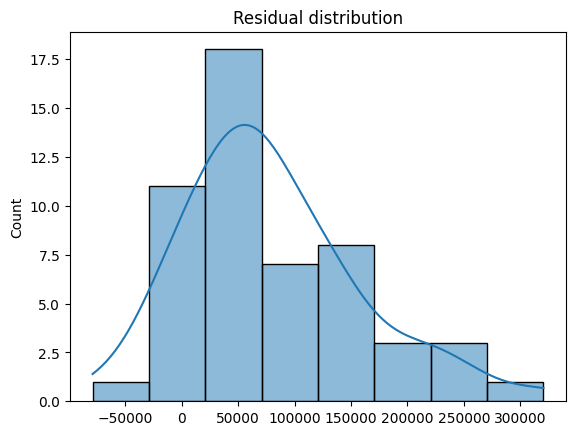

In [29]:
import seaborn as sns
sns.histplot(resid, kde=True)
plt.title('Residual distribution')
plt.show()


In [30]:
error_df = pd.DataFrame({
    'actual': test['Weekly_Sales'],
    'pred': preds['SARIMA']
})
error_df['abs_err'] = (error_df.actual - error_df.pred).abs()
display(error_df.sort_values('abs_err', ascending=False).head(10))


,actual,pred,abs_err
Date,,,
2012-04-06,1899676.88,1.579046e+06,320630.383450
2011-11-25,2033320.66,1.787885e+06,245435.515148
2012-07-06,1769854.16,1.530875e+06,238979.313555
2011-12-23,2270188.99,2.048078e+06,222111.017707
2012-02-10,1802477.43,1.600444e+06,202032.969955
2012-02-17,1819870.00,1.623070e+06,196800.309128
2011-12-09,1799682.38,1.626926e+06,172756.276130
2012-03-30,1649604.63,1.506743e+06,142861.627061
2011-12-16,1881176.67,1.744483e+06,136694.003776


Running pipeline for store 1
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


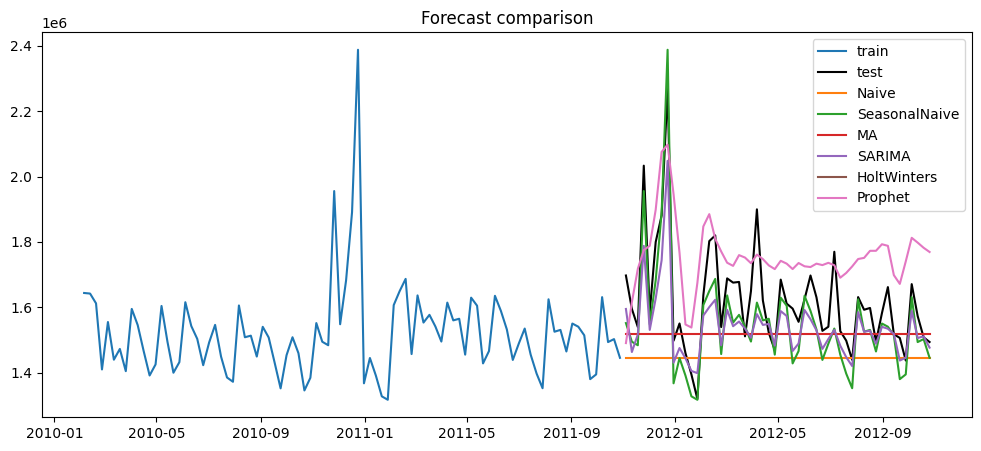

Running pipeline for store 2
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


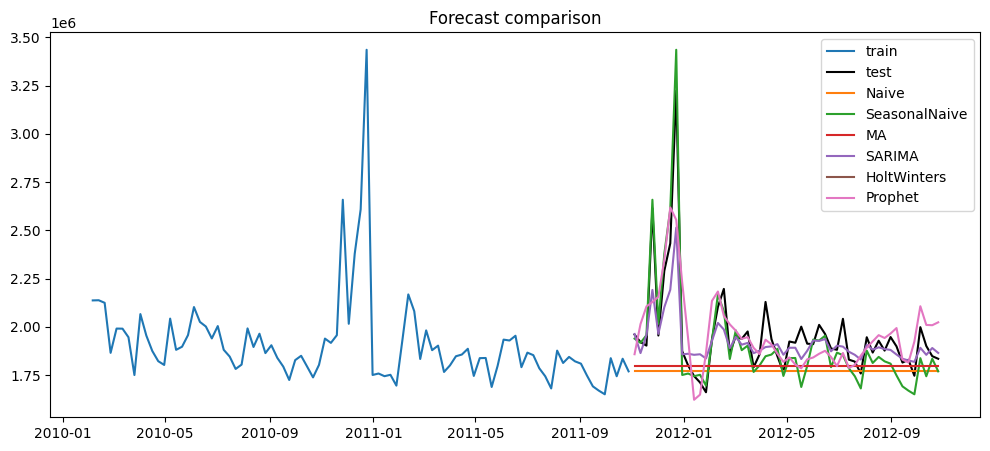

Running pipeline for store 3
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


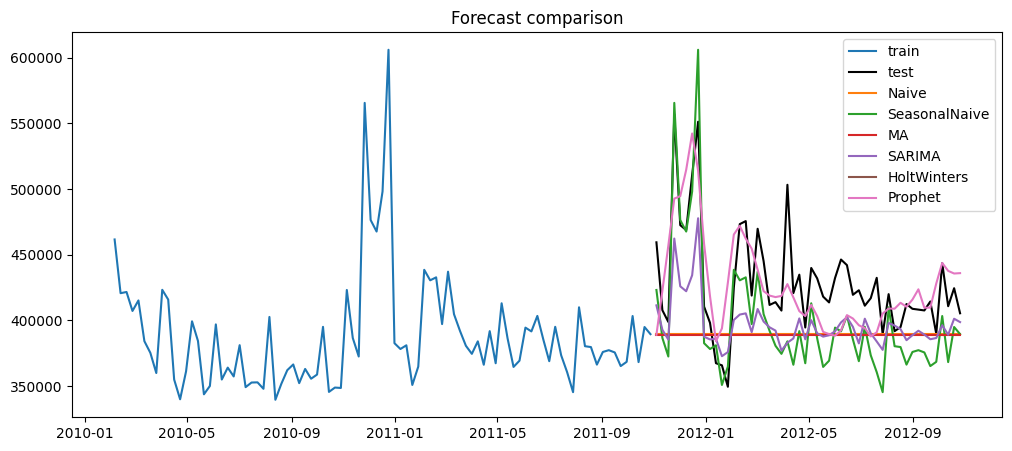

Running pipeline for store 4
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


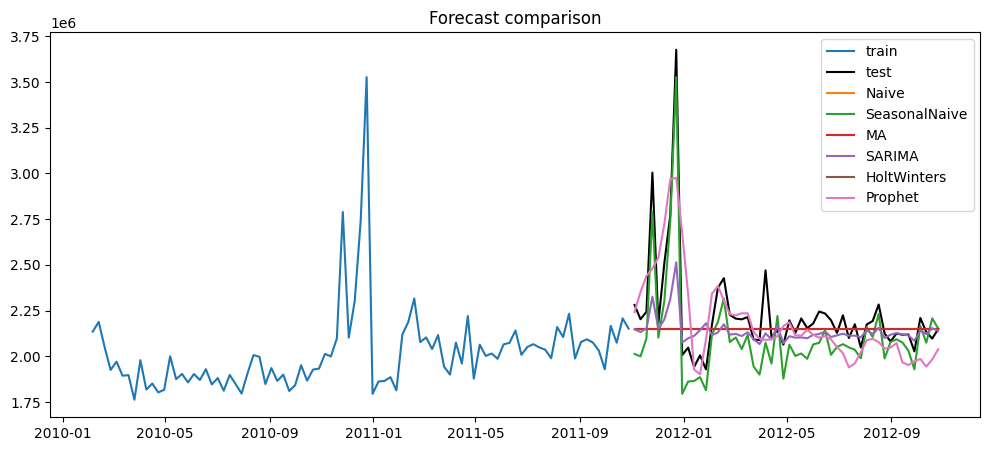

Running pipeline for store 5
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


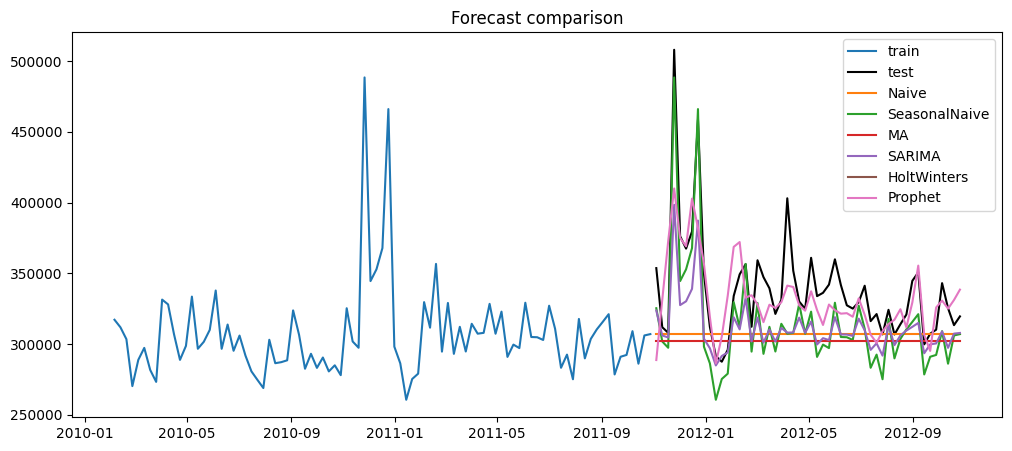

Running pipeline for store 6
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


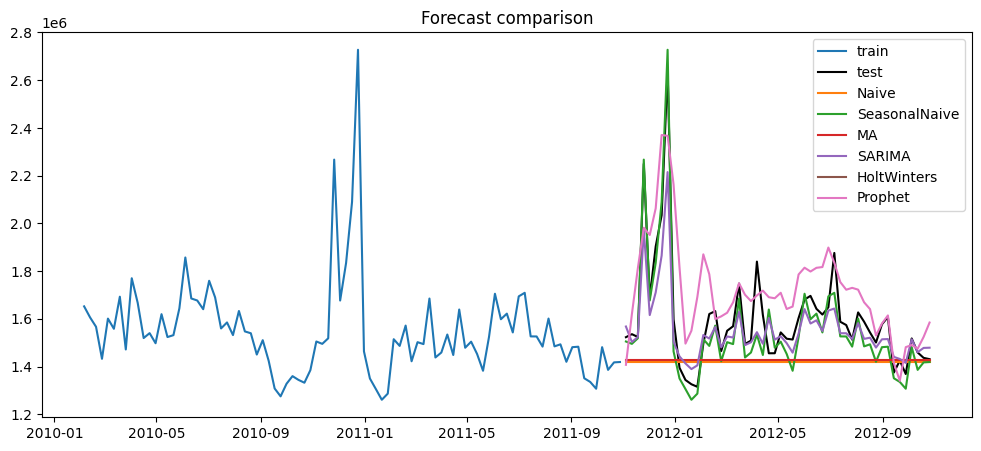

Running pipeline for store 7
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


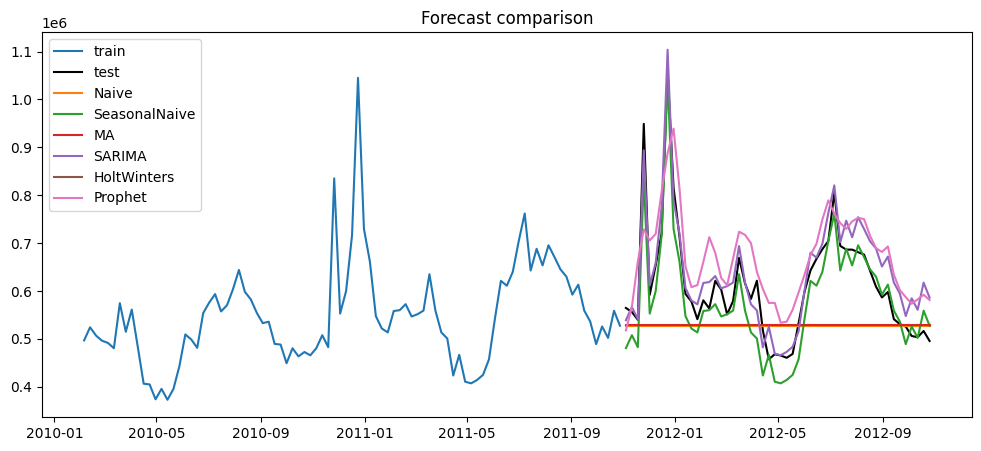

Running pipeline for store 8
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


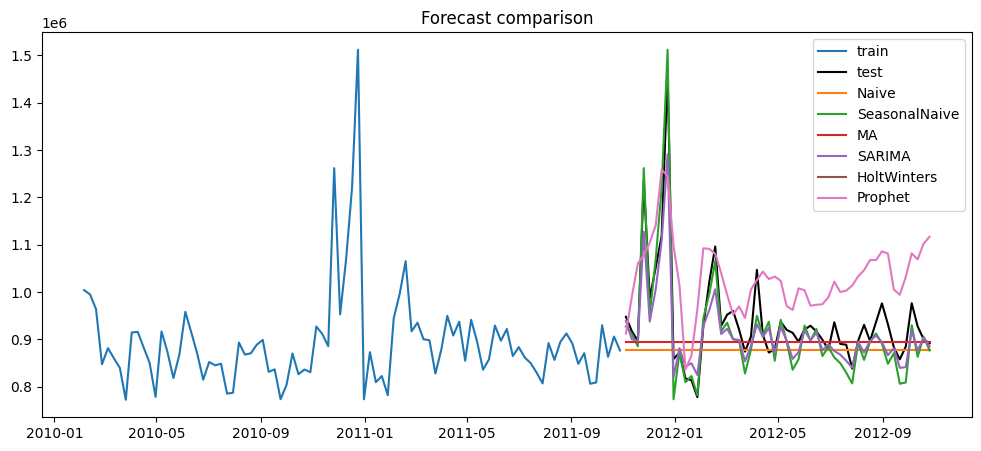

Running pipeline for store 9
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


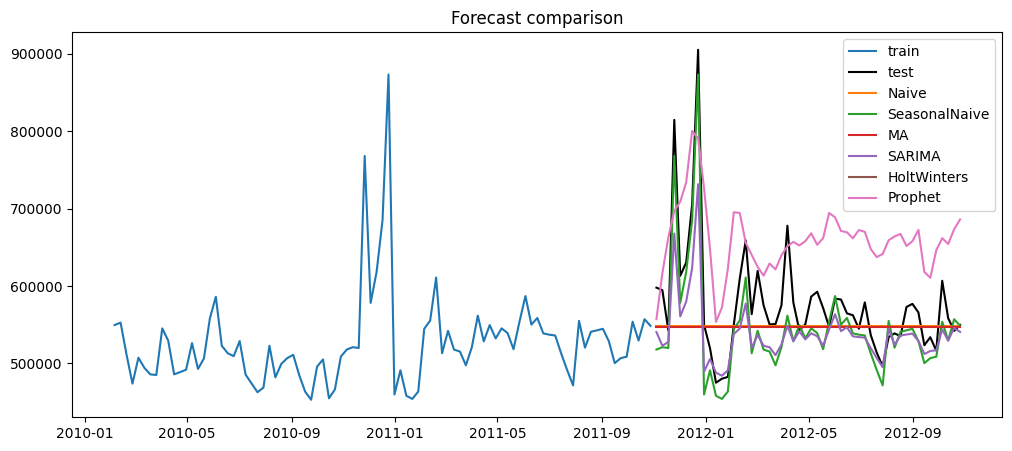

Running pipeline for store 10
Train range: 2010-02-05 00:00:00 - 2011-10-28 00:00:00
Test range: 2011-11-04 00:00:00 - 2012-10-26 00:00:00
Holt-Winters failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.


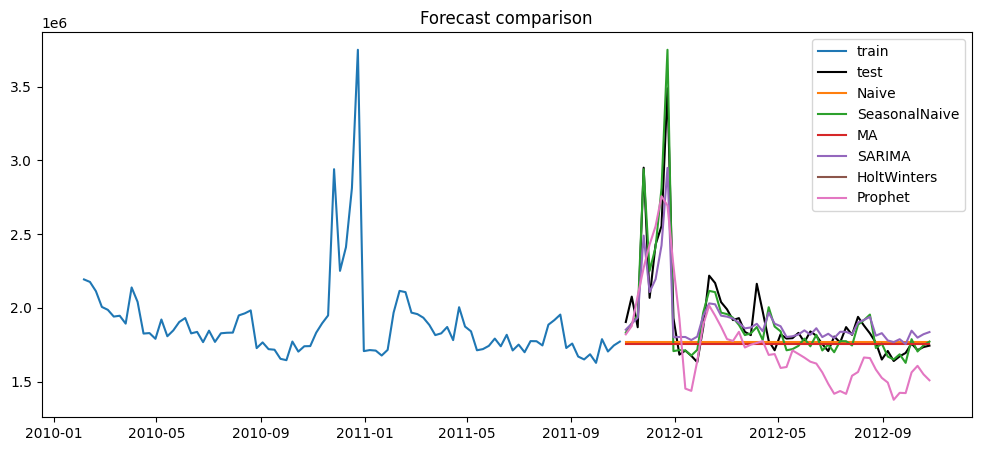

model,MA,Naive,Prophet,SARIMA,SeasonalNaive
store,,,,,
1,126481.008462,179401.169231,168911.363509,85670.813367,79533.983269
2,174168.796154,194754.247308,120246.125315,84275.633523,82846.035385
3,42308.362981,41865.850385,26829.481713,33336.637473,33115.410000
4,137218.669423,137047.030769,142078.669500,121981.403531,123944.705192
5,37316.216154,33144.865385,19677.335050,27014.068691,24936.243077
6,186769.341154,192093.676923,161224.363817,75227.478225,67577.588846
7,99959.058846,100607.869423,77873.456882,35813.366737,39097.989231
8,62867.812308,71813.140577,110876.317949,34258.656935,34544.953846
9,45454.168462,45057.659231,95388.571237,38915.916457,34056.989808


In [31]:
store_ids = df['Store'].unique().tolist()[:10]  # pick 10 stores or all
summary = []
for sid in store_ids:
    try:
        res, _ = run_store_pipeline(df, sid, n_test_weeks=52,
                                    exog_cols=['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment'])
    except Exception as e:
        print("Store", sid, "failed:", e)
        continue
    for model, m in res.items():
        if 'MAE' in m:
            summary.append({'store': sid, 'model': model, 'MAE': m['MAE'], 'RMSE': m['RMSE'], 'MAPE': m['MAPE']})
summary_df = pd.DataFrame(summary)
summary_df.to_csv('/content/drive/MyDrive/forecasting_project/results/multi_store_metrics.csv', index=False)
display(summary_df.pivot_table(index='store', columns='model', values='MAE'))


In [33]:
def multi_horizon_eval(series, model_fn, max_h=12):
    # model_fn: function(train, h) -> preds for h steps
    # simple implementation using expanding window
    errors = {h: [] for h in range(1, max_h+1)}
    # pick last 52 weeks for backtest
    for i in range(52, len(series)-max_h):
        train = series.iloc[:i]
        true = series.iloc[i:i+max_h][TARGET]
        # get prediction (you need a model function suitable for quick predictions)
        preds_h, _ = model_fn(train, true.index)  # adapt per model
        for h in range(1, max_h+1):
            errors[h].append(abs(true.iloc[h-1] - preds_h.iloc[h-1]))
    return {h: np.mean(errors[h]) for h in errors}
